In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import matplotlib.pyplot as plt
import src.fitting as fitting
import src.multielec_utils as mutils
import statsmodels.api as sm
import jax
import jax.numpy as jnp
from scipy.io import savemat, loadmat
import optax
from copy import copy, deepcopy
import multiprocessing as mp
import collections
import visionloader as vl
from matplotlib import cm

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-06-7"
wnoise = "kilosort_data000/data000"

estim_neg = "data003/data003-all"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))
spont_limit = 0.3   # this needs to be the same value as min_prob in fit_surface()
min_active_inds = 200

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps = np.array([mutils.get_stim_amps_newlv(electrical_path, 1)] * len(trials))

clean_inds_array = np.full((all_probs.shape[0], all_probs.shape[1]), 
                            None, dtype=object)

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if all_probs[i][j].max() >= spont_limit:
            print(cells[i], j+1)
            clean_inds = mutils.triplet_cleaning(amps[j], all_probs[i][j], trials[j],
                                                 return_inds=True)
            above_spont = np.where(all_probs[i][j][clean_inds] >= spont_limit)[0]
            if len(above_spont) >= min_active_inds:
                clean_inds_array[i][j] = clean_inds

81 1
84 1
84 2
85 1
96 1
112 1
170 1
171 1
171 2
222 1
222 2
224 1
241 2
242 1
242 2
244 1
244 2
248 2
250 2
259 1
259 2
263 2
275 2
282 2
283 3
289 3
292 2
296 3
301 3
302 2
302 3
304 3
399 3
535 1
621 1
626 1


In [3]:
ms = [1, 2, 3, 4, 5, 6]

w_inits_array = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [4]:
input_list = fitting.generate_input_list(all_probs, amps, trials, w_inits_array,
                                         pass_inds=clean_inds_array)

In [5]:
pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [6]:
params_true = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
inits = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)

probs_true = np.zeros(all_probs.shape)
cnt = 0
for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        params_true[i][j] = mp_output[cnt][0]
        inits[i][j] = mp_output[cnt][1]
        
        probs_true[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps[j], has_constant='add'), 
                                params_true[i][j])

        cnt += 1

In [ ]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(cells[i], j+1)
            print(params_true[i][j])
            print(len(np.where(all_probs[i][j][clean_inds_array[i][j]] >= spont_limit)[0]))
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][:, 0], 
                              amps[j][:, 1],
                              amps[j][:, 2], marker='o', 
                              c=probs_true[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][:, 0], 
                              amps[j][:, 1],
                              amps[j][:, 2], marker='o', 
                              c=all_probs[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            input()

In [11]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    p_empirical_array = np.array(p_empirical)

    return p_empirical_array

In [7]:
def sample_spikes_array(true_probs, trials, NUM_THREADS=24):

    input_list = []
    for i in range(len(true_probs)):
        for j in range(len(true_probs[i])):
            input_list += [(true_probs[i][j], trials[j])]
            
    pool = mp.Pool(processes=NUM_THREADS)
    results = pool.starmap_async(sample_spikes, input_list)
    mp_output = results.get()
    pool.close()

    return np.array(mp_output).reshape(true_probs.shape)

In [8]:
def get_performance_array(true_params, curr_probs, true_probs):
    
    error = 0
    cnt = 0
    for i in range(len(true_params)):
        for j in range(len(true_params[i])):
            if ~np.all(true_params[i][j][:, 0] == -np.inf):
                error += np.sqrt(np.sum((curr_probs[i][j] - true_probs[i][j])**2) / len(true_probs[i][j]))
                cnt += 1

    return error / cnt

In [9]:
# TOTAL CELLS IN DATASET

total_cell_cnt = 0
for i in range(len(params_true)):
    for j in range(len(params_true[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):
            total_cell_cnt += 1
print(total_cell_cnt)

7


0.05600575792792861 0.05600575792792861
Cells Found: 7/7
Optimizing trials...
0
(DeviceArray(482805.06, dtype=float32), DeviceArray(23655.682, dtype=float32), DeviceArray(755918.7, dtype=float32), DeviceArray(273113.62, dtype=float32))
1
(DeviceArray(476261.5, dtype=float32), DeviceArray(23292.986, dtype=float32), DeviceArray(742121.25, dtype=float32), DeviceArray(265859.72, dtype=float32))
2
(DeviceArray(470633.75, dtype=float32), DeviceArray(22910.96, dtype=float32), DeviceArray(728853., dtype=float32), DeviceArray(258219.22, dtype=float32))
3
(DeviceArray(465850.47, dtype=float32), DeviceArray(22510.432, dtype=float32), DeviceArray(716059.1, dtype=float32), DeviceArray(250208.62, dtype=float32))
4
(DeviceArray(461841.56, dtype=float32), DeviceArray(22092.613, dtype=float32), DeviceArray(703693.8, dtype=float32), DeviceArray(241852.27, dtype=float32))
5
(DeviceArray(458545.88, dtype=float32), DeviceArray(21658.797, dtype=float32), DeviceArray(691721.8, dtype=float32), DeviceArray(233

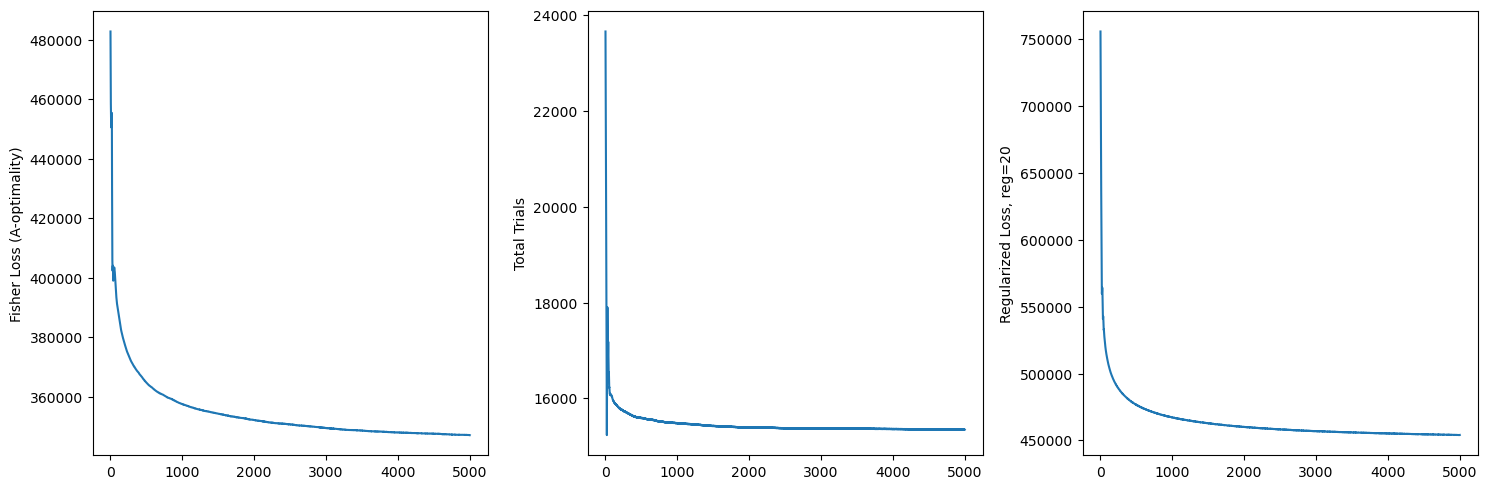

15207.0
15207.0


/tmp/ipykernel_27185/2799780796.py:241: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * np.array(T_new)[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((np.array(T_new) + T_prev)[np.newaxis, :, :])


0.014961420665222222 0.022954573113939097
Cells Found: 7/7
Optimizing trials...
0
(DeviceArray(373053.25, dtype=float32), DeviceArray(16312.484, dtype=float32), DeviceArray(499302.94, dtype=float32), DeviceArray(126249.69, dtype=float32))
1
(DeviceArray(350040.62, dtype=float32), DeviceArray(16467.127, dtype=float32), DeviceArray(479383.16, dtype=float32), DeviceArray(129342.54, dtype=float32))
2
(DeviceArray(334827., dtype=float32), DeviceArray(16316.131, dtype=float32), DeviceArray(461149.62, dtype=float32), DeviceArray(126322.62, dtype=float32))
3
(DeviceArray(322268.2, dtype=float32), DeviceArray(16380.638, dtype=float32), DeviceArray(449880.94, dtype=float32), DeviceArray(127612.75, dtype=float32))
4
(DeviceArray(311447.6, dtype=float32), DeviceArray(16700.123, dtype=float32), DeviceArray(445450.06, dtype=float32), DeviceArray(134002.47, dtype=float32))
5
(DeviceArray(303613.56, dtype=float32), DeviceArray(16788.25, dtype=float32), DeviceArray(439378.56, dtype=float32), DeviceArra

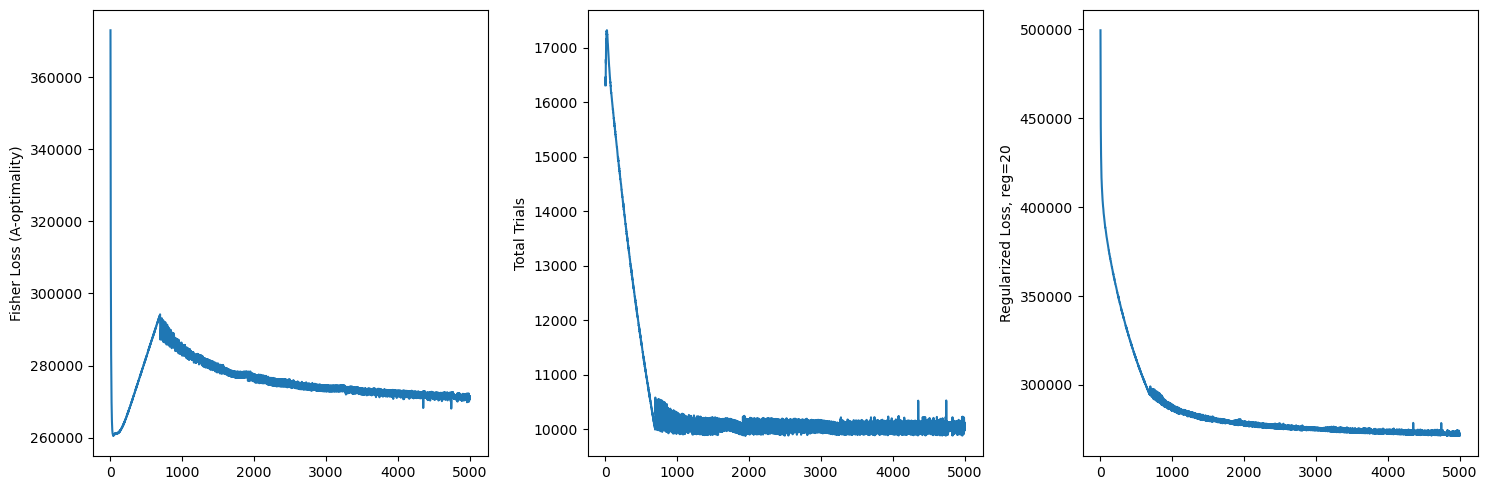

9298.0
10000.0


/tmp/ipykernel_27185/2799780796.py:241: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * np.array(T_new)[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((np.array(T_new) + T_prev)[np.newaxis, :, :])


0.01272893143778443 0.020204003665947375
Cells Found: 7/7
Optimizing trials...
0
(DeviceArray(251361.92, dtype=float32), DeviceArray(11191.976, dtype=float32), DeviceArray(275201.44, dtype=float32), DeviceArray(23839.512, dtype=float32))
1
(DeviceArray(246350.72, dtype=float32), DeviceArray(11474.75, dtype=float32), DeviceArray(275845.72, dtype=float32), DeviceArray(29495., dtype=float32))
2
(DeviceArray(243960.39, dtype=float32), DeviceArray(11363.545, dtype=float32), DeviceArray(271231.28, dtype=float32), DeviceArray(27270.898, dtype=float32))
3
(DeviceArray(243171.8, dtype=float32), DeviceArray(11027.03, dtype=float32), DeviceArray(263712.4, dtype=float32), DeviceArray(20540.605, dtype=float32))
4
(DeviceArray(243323.88, dtype=float32), DeviceArray(10621.661, dtype=float32), DeviceArray(255757.1, dtype=float32), DeviceArray(12433.223, dtype=float32))
5
(DeviceArray(243204.38, dtype=float32), DeviceArray(10428.873, dtype=float32), DeviceArray(251781.84, dtype=float32), DeviceArray(85

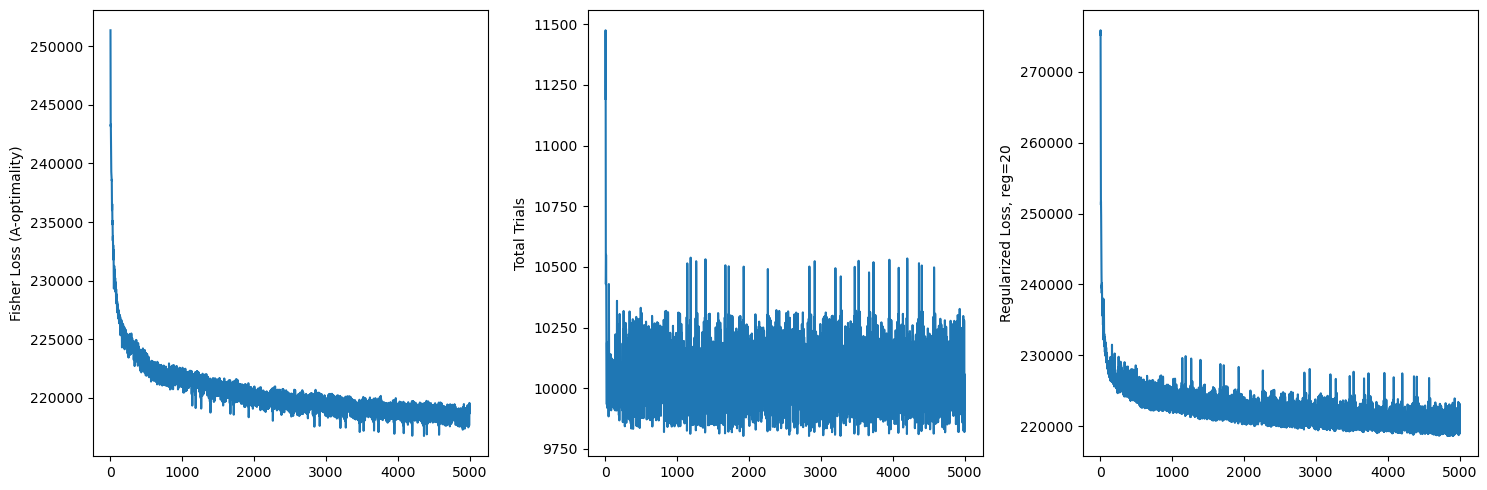

8851.0
10000.0


/tmp/ipykernel_27185/2799780796.py:241: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * np.array(T_new)[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((np.array(T_new) + T_prev)[np.newaxis, :, :])
/Volumes/Lab/Users/praful/multielectrode/src/fitting.py:274: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


0.008841541408552285 0.0183549957131442
Cells Found: 7/7
Optimizing trials...
0
(DeviceArray(161595.19, dtype=float32), DeviceArray(11111.064, dtype=float32), DeviceArray(183816.47, dtype=float32), DeviceArray(22221.29, dtype=float32))
1
(DeviceArray(161344.1, dtype=float32), DeviceArray(11191.039, dtype=float32), DeviceArray(185164.88, dtype=float32), DeviceArray(23820.781, dtype=float32))
2
(DeviceArray(162107.22, dtype=float32), DeviceArray(10841.888, dtype=float32), DeviceArray(178944.97, dtype=float32), DeviceArray(16837.754, dtype=float32))
3
(DeviceArray(163437.31, dtype=float32), DeviceArray(10265.375, dtype=float32), DeviceArray(168744.81, dtype=float32), DeviceArray(5307.5, dtype=float32))
4
(DeviceArray(164945.66, dtype=float32), DeviceArray(9673.787, dtype=float32), DeviceArray(171469.9, dtype=float32), DeviceArray(6524.258, dtype=float32))
5
(DeviceArray(164898.73, dtype=float32), DeviceArray(9728.39, dtype=float32), DeviceArray(170330.94, dtype=float32), DeviceArray(5432.

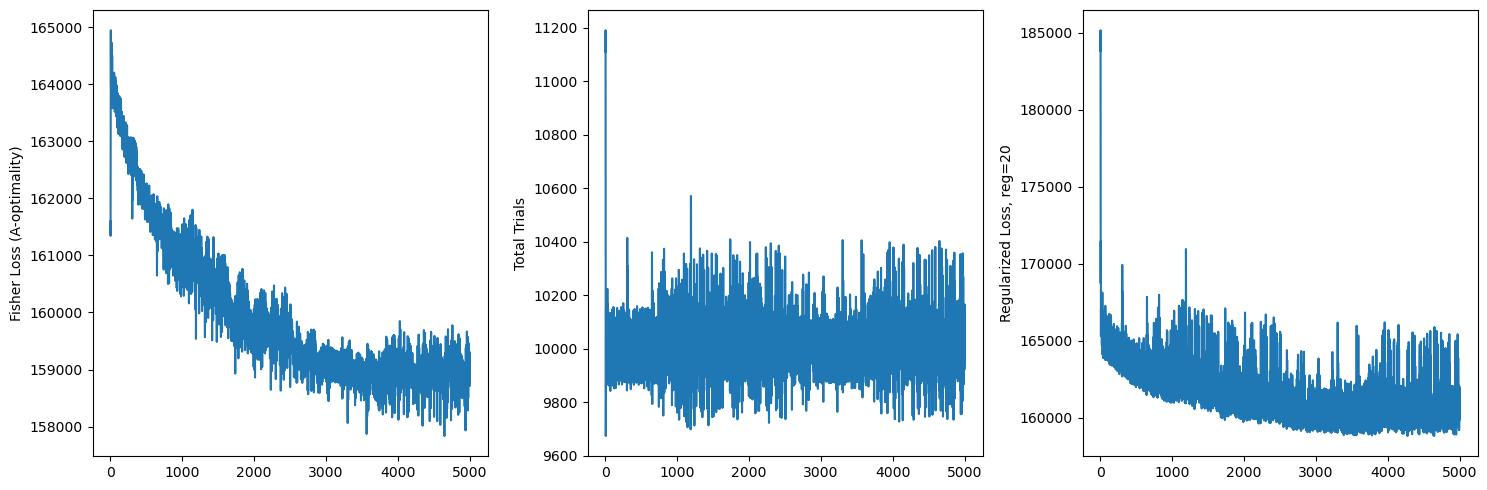

8433.0
10000.0


/tmp/ipykernel_27185/2799780796.py:241: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * np.array(T_new)[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((np.array(T_new) + T_prev)[np.newaxis, :, :])


0.01973186021926393 0.017751192137154755
Cells Found: 7/7
Optimizing trials...
0
(DeviceArray(123409.43, dtype=float32), DeviceArray(11140.405, dtype=float32), DeviceArray(146217.53, dtype=float32), DeviceArray(22808.105, dtype=float32))
1
(DeviceArray(123349.01, dtype=float32), DeviceArray(11168.305, dtype=float32), DeviceArray(146715.1, dtype=float32), DeviceArray(23366.094, dtype=float32))
2
(DeviceArray(123932.14, dtype=float32), DeviceArray(10768.117, dtype=float32), DeviceArray(139294.48, dtype=float32), DeviceArray(15362.344, dtype=float32))
3
(DeviceArray(124865.7, dtype=float32), DeviceArray(10146.525, dtype=float32), DeviceArray(127796.21, dtype=float32), DeviceArray(2930.5078, dtype=float32))
4
(DeviceArray(125872.4, dtype=float32), DeviceArray(9537.468, dtype=float32), DeviceArray(135123.05, dtype=float32), DeviceArray(9250.645, dtype=float32))
5
(DeviceArray(125974.875, dtype=float32), DeviceArray(9516.742, dtype=float32), DeviceArray(135640.03, dtype=float32), DeviceArray

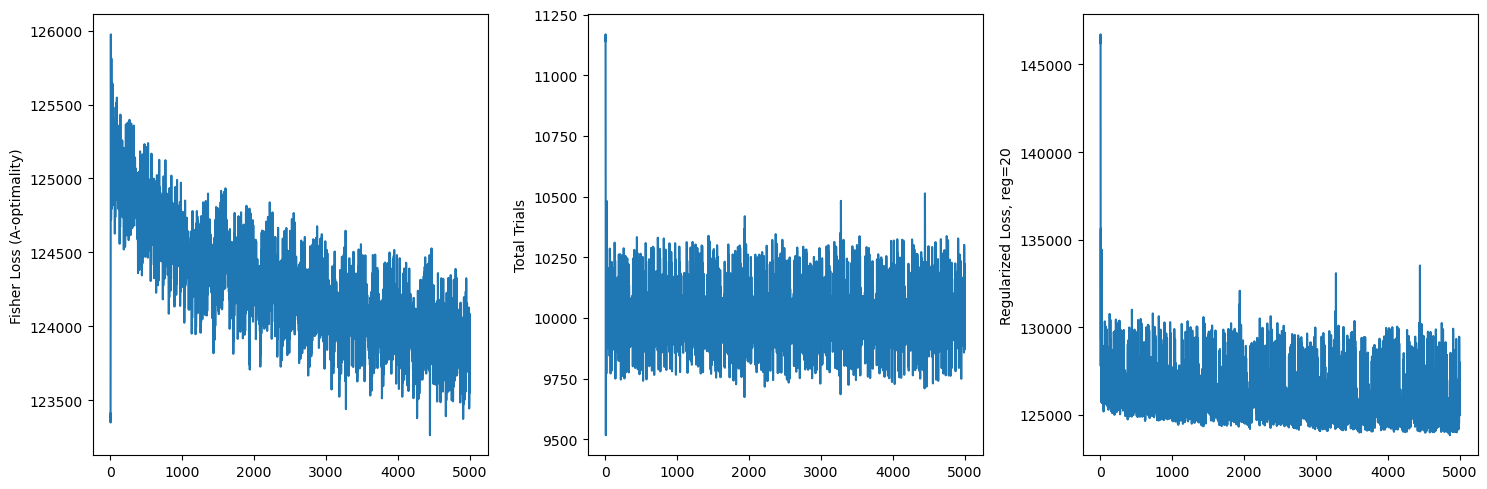

8466.0
10000.0


/tmp/ipykernel_27185/2799780796.py:241: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * np.array(T_new)[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((np.array(T_new) + T_prev)[np.newaxis, :, :])


0.006439114460710584 0.017411615491989052


In [12]:
total_budget = 50000
num_iters = 5
budget = int(total_budget / num_iters)
reg = 20    # 5
T_step_size = 0.05 # 0.005
T_n_steps = 5000
init_trials = 5
init_amps = 200
ms = [1, 2, 3, 4, 5, 6]

T_prev = np.zeros_like(trials, dtype=float)
for i in range(len(T_prev)):
    init_inds = np.random.choice(np.arange(len(T_prev[i]), dtype=int), size=init_amps,
                                 replace=False)
    T_prev[i][init_inds] = init_trials
# T_prev_random = deepcopy(T_prev)
T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true, T_prev, NUM_THREADS=24)
# probs_empirical_random = deepcopy(probs_empirical)
probs_empirical_uniform = deepcopy(probs_empirical)

X = jnp.array(sm.add_constant(amps[0], has_constant='add'))
# w_inits_array = np.zeros((probs_empirical.shape[0], probs_empirical.shape[1]), dtype=object)
# for i in range(len(w_inits_array)):
#     for j in range(len(w_inits_array[i])):
#         w_inits = []

#         for m in ms:
#             w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
#             w_inits.append(w_init)

#         w_inits_array[i][j] = w_inits

# w_inits_array_random = deepcopy(w_inits_array)
# w_inits_array_uniform = deepcopy(w_inits_array)

performances = []
# performances_random = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    w_inits_array = np.zeros((probs_empirical.shape[0], probs_empirical.shape[1]), dtype=object)
    for i in range(len(w_inits_array)):
        for j in range(len(w_inits_array[i])):
            w_inits = []

            for m in ms:
                w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
                w_inits.append(w_init)

            w_inits_array[i][j] = w_inits

    input_list = fitting.generate_input_list(probs_empirical, amps, T_prev, w_inits_array)

    pool = mp.Pool(processes=24)
    results = pool.starmap_async(fitting.fit_surface, input_list)
    mp_output = results.get()
    pool.close()

    params_curr = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
    # w_inits_array = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)

    probs_curr = np.zeros(all_probs.shape)
    cnt = 0
    for i in range(len(all_probs)):
        for j in range(len(all_probs[i])):
            params_curr[i][j] = mp_output[cnt][0]
            # w_inits_array[i][j] = mp_output[cnt][1]
            
            probs_curr[i][j] = fitting.sigmoidND_nonlinear(
                                    sm.add_constant(amps[j], has_constant='add'), 
                                    params_curr[i][j])

            cnt += 1

    if iter_cnt == 0:
        # probs_curr_random = deepcopy(probs_curr)     # this is only for iteration 0
        probs_curr_uniform = deepcopy(probs_curr)
        
        # random_draws = np.random.choice(len(T_prev.flatten()), size=budget)
        # T_new_init = jnp.array(np.bincount(random_draws, minlength=len(T_prev.flatten())).astype(int).reshape(T_prev.shape), dtype=float)
        T_new_init = jnp.ones_like(jnp.array(T_prev), dtype=float)
        # w_inits_array_random = deepcopy(w_inits_array)
        # w_inits_array_uniform = deepcopy(w_inits_array)

    else:
        T_new_init = jnp.absolute(t_final)

        # w_inits_array_random = np.zeros((probs_empirical.shape[0], probs_empirical.shape[1]), dtype=object)
        # for i in range(len(w_inits_array_random)):
        #     for j in range(len(w_inits_array_random[i])):
        #         w_inits = []

        #         for m in ms:
        #             w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
        #             w_inits.append(w_init)

        #         w_inits_array_random[i][j] = w_inits

        # input_list_random = fitting.generate_input_list(probs_empirical_random, amps, T_prev_random, w_inits_array_random)

        # pool = mp.Pool(processes=24)
        # results_random = pool.starmap_async(fitting.fit_surface, input_list_random)
        # mp_output_random = results_random.get()
        # pool.close()

        # params_curr_random = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
        # # w_inits_array_random = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)

        # probs_curr_random = np.zeros(all_probs.shape)
        # cnt = 0
        # for i in range(len(all_probs)):
        #     for j in range(len(all_probs[i])):
        #         params_curr_random[i][j] = mp_output_random[cnt][0]
        #         # w_inits_array_random[i][j] = mp_output_random[cnt][1]
                
        #         probs_curr_random[i][j] = fitting.sigmoidND_nonlinear(
        #                                 sm.add_constant(amps[j], has_constant='add'), 
        #                                 params_curr_random[i][j])

        #         cnt += 1

        w_inits_array_uniform = np.zeros((probs_empirical.shape[0], probs_empirical.shape[1]), dtype=object)
        for i in range(len(w_inits_array_uniform)):
            for j in range(len(w_inits_array_uniform[i])):
                w_inits = []

                for m in ms:
                    w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
                    w_inits.append(w_init)

                w_inits_array_uniform[i][j] = w_inits

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps, T_prev_uniform, w_inits_array_uniform)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)
        # w_inits_array_uniform = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)

        probs_curr_uniform = np.zeros(all_probs.shape)
        cnt = 0
        for i in range(len(all_probs)):
            for j in range(len(all_probs[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                # w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

    performance = get_performance_array(params_true, probs_curr, probs_true)
    # performance_random = get_performance_array(params_true, probs_curr_random, probs_true)
    performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true)

    performances.append(performance)
    # performances_random.append(performance_random)
    performances_uniform.append(performance_uniform)

    print(performance, performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))
    if iter_cnt >= num_iters:
        break

    jac_dict = collections.defaultdict(dict)
    transform_mat = []
    probs_vec = []
    cell_cnt = 0
    num_params = 0
    for i in range(len(params_curr)):
        for j in range(len(params_curr[i])):
            if ~np.all(params_curr[i][j][:, 0] == -np.inf):
                # jac_dict[i][j] = activation_probs_jac(X, jnp.array(params_curr[i][j]))
                jac_dict[i][j] = jax.jacfwd(fitting.activation_probs, argnums=1)(X, jnp.array(params_curr[i][j])).reshape((len(X), params_curr[i][j].shape[0]*params_curr[i][j].shape[1]))  # c x l
                num_params += jac_dict[i][j].shape[1]

                transform = jnp.zeros(len(T_prev))
                transform = transform.at[j].set(1)
                transform_mat.append(transform)     # append a e-vector (512)

                probs_vec.append(probs_curr[i][j])  # append a c-vector (80)
                cell_cnt += 1

    transform_mat = jnp.array(transform_mat)
    probs_vec = jnp.hstack(probs_vec)

    jac_full = jnp.zeros((len(probs_vec), num_params))
    counter_axis0 = 0
    counter_axis1 = 0
    for i in jac_dict.keys():
        for j in jac_dict[i].keys():
            next_jac = jac_dict[i][j]

            jac_full = jac_full.at[counter_axis0:counter_axis0+next_jac.shape[0], counter_axis1:counter_axis1+next_jac.shape[1]].set(next_jac)

            counter_axis0 += next_jac.shape[0]
            counter_axis1 += next_jac.shape[1]

    print(f'Cells Found: {cell_cnt}/{total_cell_cnt}')
    # break

    print('Optimizing trials...')
    # reg = 3.0 * cell_cnt
    losses, t_final = fitting.optimize_fisher_array(jac_full, probs_vec, transform_mat, jnp.array(T_prev), T_new_init, step_size=T_step_size,
                                            n_steps=T_n_steps, reg=reg, T_budget=budget)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(losses[:, 0])
    axs[0].set_ylabel('Fisher Loss (A-optimality)')
    axs[1].plot(losses[:, 1])
    axs[1].set_ylabel('Total Trials')
    axs[2].plot(losses[:, 2])
    axs[2].set_ylabel('Regularized Loss, reg=' + str(reg))

    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    plt.show()

    T_new = jnp.round(jnp.absolute(t_final), 0)
    print(jnp.sum(T_new))

    if jnp.sum(T_new) < budget:
        random_extra = np.random.choice(len(T_new.flatten()), size=int(budget - jnp.sum(T_new)),
                                        p=np.array(jnp.absolute(t_final.flatten()))/np.sum(np.array(jnp.absolute(t_final.flatten()))))
        T_new_extra = jnp.array(np.bincount(random_extra, minlength=len(T_new.flatten())).astype(int).reshape(T_new.shape))
        T_new = T_new + T_new_extra

    print(jnp.sum(T_new))

    p_new = sample_spikes_array(probs_true, np.array(T_new), NUM_THREADS=24)
    p_tmp = (p_new * np.array(T_new)[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((np.array(T_new) + T_prev)[np.newaxis, :, :])
    T_tmp = np.array(T_new) + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp

    # random_draws = np.random.choice(len(T_new.flatten()), size=int(jnp.sum(T_new)))
    # T_new_random = np.bincount(random_draws, minlength=len(T_new.flatten())).astype(int).reshape(T_new.shape)
    # p_new_random = sample_spikes_array(probs_true, T_new_random, NUM_THREADS=24)
    
    # p_tmp_random = (p_new_random * T_new_random[np.newaxis, :, :] + probs_empirical_random * T_prev_random[np.newaxis, :, :]) / ((T_prev_random + T_new_random)[np.newaxis, :, :])
    # T_tmp_random = T_prev_random + T_new_random

    # probs_empirical_random = p_tmp_random
    # T_prev_random = T_tmp_random

    T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    p_new_uniform = sample_spikes_array(probs_true, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

    iter_cnt += 1

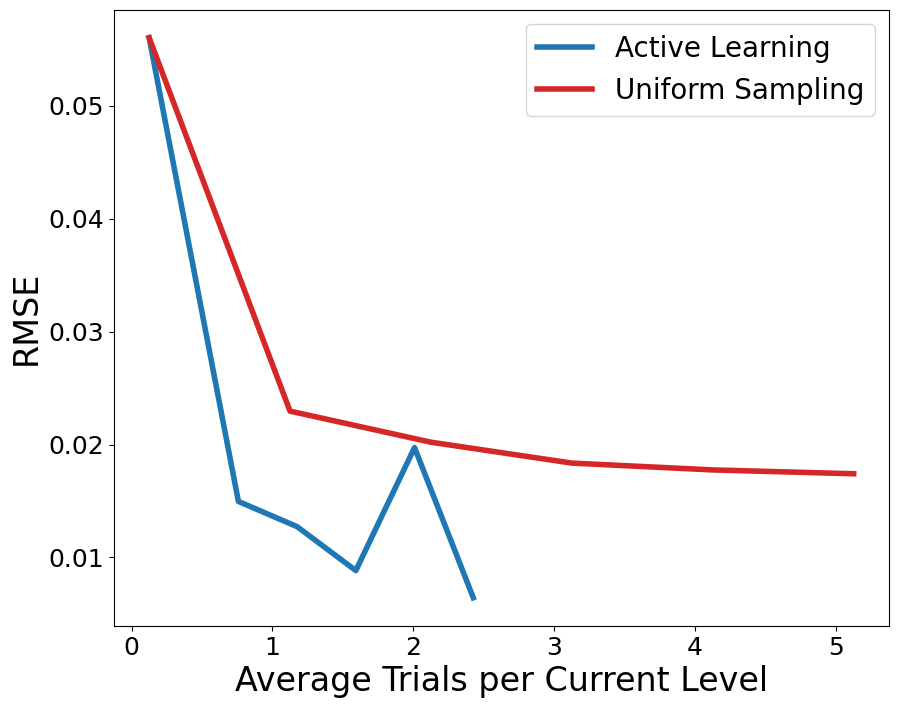

In [13]:
plt.figure(figsize=(10, 8))
# plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack), 0), 
#              yerr=np.std(np.array(performance_stack), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Active Learning', c='tab:blue', alpha=0.3)
# plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack_random), 0), 
#              yerr=np.std(np.array(performance_stack_random), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Random Baseline', c='tab:orange', alpha=0.3)

plt.plot(np.array(num_samples)/trials.shape[0]/trials.shape[1], performances, linewidth=4, c='tab:blue', label='Active Learning')
# plt.plot(np.array(num_samples)/trials.shape[0]/trials.shape[1], performances_random, linewidth=4, c='tab:orange', label='Random Baseline')
plt.plot(np.array(num_samples_uniform)/trials.shape[0]/trials.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Uniform Sampling')

# plt.axhline(get_performance_array(params_true, probs_curr_baseline, probs_true), c='k', linestyle='--', linewidth=2, label='20 Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20, loc='best')


# plt.savefig('performances_5step_p2_n259_adamw.png', dpi=300)

In [ ]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(cells[i], j+1)
            print(params_true[i][j])
            print(len(np.where(all_probs[i][j][clean_inds_array[i][j]] >= spont_limit)[0]))

            sampled_inds = np.where(np.round(np.array(jnp.absolute(t_final[j]))) > 0)[0]
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][:, 0], 
                              amps[j][:, 1],
                              amps[j][:, 2], marker='o', 
                              c=probs_true[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][:, 0], 
                              amps[j][:, 1],
                              amps[j][:, 2], marker='o', 
                              c=probs_curr[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][sampled_inds, 0], 
                              amps[j][sampled_inds, 1],
                              amps[j][sampled_inds, 2], marker='o', 
                              c=probs_empirical[i][j][sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            input()

In [ ]:
# BUG FOUND: should be initializing with jnp.absolute(t_final) in other files

In [ ]:
baseline_trials = 20
T_baseline = np.ones_like(trials, dtype=float) * baseline_trials
probs_baseline = sample_spikes_array(probs_true, T_baseline, NUM_THREADS=24)

X = jnp.array(sm.add_constant(amps[0], has_constant='add'))
w_inits_array_baseline = np.zeros((probs_baseline.shape[0], probs_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_baseline, amps, T_baseline, w_inits_array_baseline)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((all_probs.shape[0], all_probs.shape[1]), dtype=object)

probs_curr_baseline = np.zeros(all_probs.shape)
cnt = 0
for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

cell_cnt = 0
for i in range(len(params_curr_baseline)):
    for j in range(len(params_curr_baseline[i])):
        if ~np.all(params_curr_baseline[i][j][:, 0] == -np.inf):
            cell_cnt += 1
                
print(f'Cells Found: {cell_cnt}/{total_cell_cnt}')
print(get_performance_array(params_true, probs_curr_baseline, probs_true))

In [ ]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(all_probs)):
    for j in range(len(all_probs[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(cells[i], j+1)
            print(params_true[i][j])
            print(len(np.where(all_probs[i][j][clean_inds_array[i][j]] >= spont_limit)[0]))
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][:, 0], 
                              amps[j][:, 1],
                              amps[j][:, 2], marker='o', 
                              c=probs_true[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps[j][:, 0], 
                              amps[j][:, 1],
                              amps[j][:, 2], marker='o', 
                              c=probs_curr_baseline[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            input()

# Old stuff below

In [ ]:
%matplotlib inline

total_budget = 10000
num_iters = 5
budget = int(total_budget / num_iters)
reg = 20    #np.flip(np.logspace(-5, 3, 100000, base=2))
num_restarts = 1
T_step_size = 0.01 #0.01
T_n_steps = 5000

init_size = 200
init_trials = 5

performance_stack = []
performance_stack_random = []
num_samples_stack = []

for restart in range(num_restarts):
    print('Restart', restart + 1)
    # Initialize amplitudes
    init_inds = np.random.choice(len(X), replace=False, size=init_size)

    # Initialize trials
    T_prev = jnp.zeros(len(X_expt_orig))
    T_prev = T_prev.at[init_inds].set(init_trials)
    T_prev_random = jnp.copy(T_prev)

    p_empirical = jnp.array(sample_spikes(p_true, T_prev))
    p_empirical_random = jnp.copy(p_empirical)

    performances = []
    performances_random = []
    num_samples = []

    w_inits = []
    for m in ms:
        w_init = np.array(np.random.normal(size=(m, X.shape[1]+1)))
        w_inits.append(w_init)

    w_inits_random = copy(w_inits)

    cnt = 0

    while True:
        num_samples.append(np.sum(np.absolute(np.array(T_prev)).astype(int)))
        sampled_inds = np.where(np.absolute(np.array(T_prev)).astype(int) > 0)[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
                    X_expt_orig[sampled_inds, 1],
                    X_expt_orig[sampled_inds, 2], marker='o', c=p_empirical[sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)
        # scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
        #             X_expt_orig[sampled_inds, 1],
        #             X_expt_orig[sampled_inds, 2], marker='o', c=T_prev[sampled_inds], s=20, cmap=cm.jet, vmin=0, vmax=20)

        plt.show()

        sampled_inds_random = np.where(np.absolute(np.array(T_prev_random)).astype(int) > 0)[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
                    X_expt_orig[sampled_inds_random , 1],
                    X_expt_orig[sampled_inds_random , 2], marker='o', c=p_empirical_random[sampled_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

        # scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
        #     X_expt_orig[sampled_inds_random , 1],
        #     X_expt_orig[sampled_inds_random , 2], marker='o', c=T_prev_random[sampled_inds_random], s=20, cmap=cm.jet, vmin=0, vmax=20)

        plt.show()

        good_inds = jnp.where((p_empirical[sampled_inds] > 0) & (p_empirical[sampled_inds] < 1))[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_expt_orig[sampled_inds[good_inds], 0], 
                    X_expt_orig[sampled_inds[good_inds], 1],
                    X_expt_orig[sampled_inds[good_inds], 2], marker='o', c=p_empirical[sampled_inds][good_inds], 
                    s=20, alpha=0.8, vmin=0, vmax=1)
        # scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
        #             X_expt_orig[sampled_inds, 1],
        #             X_expt_orig[sampled_inds, 2], marker='o', c=T_prev[sampled_inds], s=20, cmap=cm.jet, vmin=0, vmax=20)

        plt.show()

        output = fitting.fit_triplet_surface_new(np.array(X[sampled_inds][good_inds]), 
                                              np.array(p_empirical[sampled_inds][good_inds]),
                                              np.array(T_prev[sampled_inds][good_inds], dtype=int), w_inits,
                                              method=method, jac=jac, reg_method='l2', 
                                              reg=l2_reg, R2_thresh=R2_thresh, verbose=True)
        w_final = jnp.array(output[0])
        w_inits = output[1]

        print(w_final)

        if cnt == 0:
            T_new_init = jnp.zeros(len(T_prev)) + 1
            w_final_random = jnp.copy(w_final)
            w_inits_random = copy(w_inits)
        else:
            T_new_init = t_final
            good_inds_random = jnp.where((p_empirical_random[sampled_inds_random] > 0) & (p_empirical_random[sampled_inds_random] < 1))[0]
            
            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(X_expt_orig[sampled_inds_random[good_inds_random] , 0], 
                        X_expt_orig[sampled_inds_random[good_inds_random] , 1],
                        X_expt_orig[sampled_inds_random[good_inds_random] , 2], marker='o', 
                        c=p_empirical_random[sampled_inds_random][good_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

            # scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
            #     X_expt_orig[sampled_inds_random , 1],
            #     X_expt_orig[sampled_inds_random , 2], marker='o', c=T_prev_random[sampled_inds_random], s=20, cmap=cm.jet, vmin=0, vmax=20)

            plt.show()
            
            output = fitting.fit_triplet_surface_new(np.array(X[sampled_inds_random][good_inds_random]), 
                                              np.array(p_empirical_random[sampled_inds_random][good_inds_random]),
                                              np.array(T_prev_random[sampled_inds_random][good_inds_random], dtype=int),
                                              w_inits_random, method=method, jac=jac, reg_method='l2', 
                                              reg=l2_reg, R2_thresh=R2_thresh, verbose=True)
            w_final_random = jnp.array(output[0])
            w_inits_random = output[1]

        print(w_final_random)

        performance = get_performance_AL(jnp.array(sm.add_constant(X, has_constant='add')), w_final, p_true)
        performances.append(performance)
        
        performance_random = get_performance_AL(jnp.array(sm.add_constant(X, has_constant='add')), w_final_random, p_true)
        performances_random.append(performance_random)

        print(performance, performance_random)
        # print('\n')

        if cnt >= num_iters:
            break
        
        losses, t_final = optimize_fisher(jnp.array(sm.add_constant(X, has_constant='add')), w_final, T_prev, T_new_init, reg=reg, step_size=T_step_size, n_steps=T_n_steps, T_budget=budget)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].plot(losses[:, 0])
        axs[0].set_ylabel('Fisher Loss (A-optimality)')
        axs[1].plot(losses[:, 1])
        axs[1].set_ylabel('Total Trials')
        axs[2].plot(losses[:, 2])
        axs[2].set_ylabel('Regularized Loss, reg=' + str(reg))

        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        plt.show()

        T_new = jnp.round(jnp.absolute(t_final), 0)#(t_final + T_new_explore), 0)
        print(jnp.sum(T_new))
        plt.figure()
        plt.plot(T_new)
        plt.show()

        if jnp.sum(T_new) < budget:
            random_extra = np.random.choice(len(X), size=int(budget - jnp.sum(T_new)), 
                                            p=np.array(jnp.absolute(t_final))/np.sum(np.array(jnp.absolute(t_final))))
            T_new_extra = jnp.array(np.bincount(random_extra, minlength=len(X))).astype(int)
            T_new = T_new + T_new_extra
            
            print(jnp.sum(T_new))
            plt.figure()
            plt.plot(T_new)
            plt.show()

        p_new = jnp.array(sample_spikes(p_true, T_new))

        p_tmp = (p_new * T_new + p_empirical * T_prev) / (T_prev + T_new)
        T_tmp = T_prev + T_new
        p_tmp = p_tmp.at[jnp.isnan(p_tmp)].set(0.5)

        p_empirical = p_tmp
        T_prev = T_tmp

        # print(jnp.sum(T_tmp))

        random_draws = np.random.choice(len(X), size=int(jnp.sum(T_new)))
        T_new_random = jnp.array(np.bincount(random_draws, minlength=len(X))).astype(int)
        p_new_random = jnp.array(sample_spikes(p_true, T_new_random))
        
        p_tmp_random = (p_new_random * T_new_random + p_empirical_random * T_prev_random) / (T_prev_random + T_new_random)
        T_tmp_random = T_prev_random + T_new_random
        p_tmp_random = p_tmp_random.at[jnp.isnan(p_tmp_random)].set(0.5)

        p_empirical_random = p_tmp_random
        T_prev_random = T_tmp_random

        cnt += 1
        

        # input()
    
    performance_stack.append(performances)
    performance_stack_random.append(performances_random)
    num_samples_stack.append(num_samples)

In [ ]:
savemat('sampling_map_p3_n296.mat', {'X': np.array(X_expt_orig),
                                     'p_empirical': np.array(p_empirical),
                                     'sampled_inds': np.array(sampled_inds), 
                                     'T': np.array(T_prev),
                                     'init_inds': init_inds})

In [ ]:
%matplotlib ipympl

fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
ax.view_init(elev=16., azim=-50)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

T_prev_tmp = T_prev.at[init_inds].set(T_prev[init_inds]-init_trials)
sampled_inds_tmp = np.where(np.absolute(np.array(T_prev_tmp)).astype(int) > 0)[0]
scat = ax.scatter(X_expt_orig[sampled_inds_tmp, 0], 
            X_expt_orig[sampled_inds_tmp, 1],
            X_expt_orig[sampled_inds_tmp, 2], marker='o', c=T_prev_tmp[sampled_inds_tmp], s=20, cmap=cm.jet, vmin=0, vmax=20)

plt.show()

In [ ]:
# savemat('performances_5step_p2_n259_adamw.mat', {'performance_stack': np.array(performance_stack),
#                                                 'performance_stack_random': np.array(performance_stack_random)})

In [ ]:
%matplotlib inline

plt.figure(figsize=(10, 8))
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack), 0), 
             yerr=np.std(np.array(performance_stack), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Active Learning', c='tab:blue', alpha=0.3)
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack_random), 0), 
             yerr=np.std(np.array(performance_stack_random), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Random Baseline', c='tab:orange', alpha=0.3)

# plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Trials Sampled', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)
# plt.ylim(0.36, 0.4)

# plt.savefig('performances_5step_p2_n259_adamw.png', dpi=300)

In [ ]:
w_true_t, w_true_nt

In [ ]:
all_combos = fitting.all_combos(np.arange(len(cells)))
ws_full = []
for i in range(len(cells)):
    ws_full.append(np.array(ws[i]))

ws_active = []
ws_active += [np.array(w_final_t)]
ws_active += [np.array(w_final_nt)]

for j in all_combos:
    combo = np.array(j)
    if len(combo) != 0 and len(combo) != len(cells):
        targets = combo
        selectivities_full.append(fitting.selectivity_triplet(ws_full, targets))
        selectivities_active.append(fitting.selectivity_triplet(ws_active, targets))
        datasets.append((dataset, wnoise, estim, p, cells, cells[targets]))

In [ ]:
selectivities_full, selectivities_active

In [ ]:
datasets

In [ ]:
x = np.array(selectivities_full)[:, 1]
y = np.vstack((np.array(selectivities_full)[:, 0], np.array(selectivities_active)[:, 0])).T

lines = []
for i, j in zip(x, y):
    pair = [(i, j[0]), (i, j[1])]
    lines.append(pair)

linecoll = matcoll.LineCollection(lines, colors='k')

fig, ax = plt.subplots()
ax.plot(x, [i for (i,j) in y], 's', c='tab:blue', markersize = 10, alpha=0.8, label='Full Dataset')
ax.plot(x, [j for (i,j) in y], 'o', c='tab:red', markersize = 10, alpha=0.8, label='Subsampled Dataset')
ax.add_collection(linecoll)
ax.plot(np.linspace(-0.01, 1.01, 100), np.linspace(-0.01, 1.01, 100), linestyle='--', c='k')
ax.set_xlabel('Single-Electrode Selectivity', fontsize=22)
ax.set_ylabel('Triplet Selectivity', fontsize=22)
ax.tick_params('both', labelsize=18)
ax.legend(fontsize=16)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig('fig2_NER.png', dpi=300)

In [ ]:
np.save('selectivities_full.npy', np.array(selectivities_full))
np.save('selectivities_active.npy', np.array(selectivities_active))
np.save('datasets.npy', np.array(datasets, dtype=object))